# 4.5 Assessing Downscaled Climate Projections

Once satisfied with the quality of the historical downscaled data, one can proceed with analyzing the downscaled future projections from the model. Since of course there are no observations of the future, we cannot do *validation* of the projected changes per se, but we can check that the changes/trends make physical sense, and are statistically significant in the context of natural climate variability. We did similar work in Chapter 3.4, but this time we will apply those methods to the downscaled data. In principle, the projected changes from the downscaled data should be similar to those from the raw, unadjusted model output, just with more spatial detail and with, at minimum, the effects of mean model biases diminished. Multivariate downscaling methods may introduce qualitative changes to the downscaled projections relative to the raw model projections because of differing changes to the different input variables, so this may not always be true. However, it is a good rule of thumb as a first pass check.

Continuing with our example from Chapter 4.4, and the focus on extreme climate indices, let's calculate the projected change in the number of Tropical Nights between 1971-2000 and 2071-2100, using the both the uncorrected and downscaled GCM data. This way we can see the effects of the downscaling, and compare the climate change signals between the two sets of data. Since BCCAQv2, the downscaling method used by PCIC, is a univariate method, the climate change signal should not be substantially different from that of the raw data.

Click to reveal the cells below, which import the necessary packages and acquire the appropriate datasets.

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
spkws = dict(projection = ccrs.PlateCarree(), transform = ccrs.PlateCarree())

from siphon.catalog import TDSCatalog
from xclim.core.calendar import convert_calendar, percentile_doy
import xclim.indices as xci

# for getting data from Google Cloud 
import gcsfs
import zarr

# url for the CSV file that contains the data catalog
url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

# centre of domain to analyze - same as for section 4.3 but slightly larger so we can fit multiple grid cells
lat_mtl = 45.5019
lon_mtl = -73.5674

# bounds of domain
lons = [lon_mtl - 2.5, lon_mtl + 2.5]
lats = [lat_mtl - 0.25, lat_mtl + 4.75]


In [2]:
# acquire downscaled data from PAVICS - same as section 4.4
url_pavics = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/"
url_downscaled = url_pavics + "simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/catalog.xml"
cat_sds = TDSCatalog(url_downscaled)

# open the downscaled gcm dataset and load the tasmax data
opendap_urls = [cat_sds.datasets[i].access_urls["OPENDAP"] for i in range(len(cat_sds.datasets))]
datasets_canesm_sds = list(filter(lambda x: 'CanESM' in x, opendap_urls))

url_sds = datasets_canesm_sds[0] 
print(url_sds)
ds_sds = xr.open_dataset(url_sds)
ds_sds = ds_sds.sel(lat = slice(*lats), lon = slice(*lons))

# select GCM data for historical and future periods
data_sds_hist = ds_sds.tasmin.sel(time = ds_sds.time.dt.year.isin(range(1971, 2001)))
data_sds_future = ds_sds.tasmin.sel(time = ds_sds.time.dt.year.isin(range(2071, 2101)))

https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip6/pcic/CanDCS-U6/day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp585_r9i1p2f1_gn_1950-2100.ncml


In [3]:
# get the data for the raw simulation from Google Cloud for this same ensemble member.
# Since we're accessing the Zarr stores remotely, we don't need to download and save the
# whole data files, but you can if you like, and you should save the data if you plan
# to use it for a real study

# open the Google Cloud model data catalog using pandas
df_catalog = pd.read_csv(url_catalog)

# search the Google Cloud archive for the raw model data corresponding to the same
# ensemble member as the downscaled data
search_string = "table_id == 'day' & source_id == 'CanESM5' & variable_id == 'tasmin' & member_id=='r9i1p2f1'" 
# continue on the next line
search_string += " & experiment_id == ['historical', 'ssp585']"
df_search = df_catalog.query(search_string)
df_search

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
90092,CMIP,CCCma,CanESM5,historical,r9i1p2f1,day,tasmin,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
93167,ScenarioMIP,CCCma,CanESM5,ssp585,r9i1p2f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,NaN,20190429


In [4]:
# get the URLs for the historical and SSP5-8.5 scenarios
url_hist_raw = df_search[df_search.experiment_id == 'historical']['zstore'].values[0]
url_future_raw = df_search[df_search.experiment_id == 'ssp585']['zstore'].values[0]

In [5]:
# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# use the gcfs package to turn the URLs into interfaces to the data sets
mapper_hist_raw = gcs.get_mapper(url_hist_raw)
mapper_future_raw = gcs.get_mapper(url_future_raw)

In [6]:
ds_hist_raw = xr.open_zarr(mapper_hist_raw, consolidated = True)

# get lons bounds on [0, 360] scal
lons360 = [l + 360 for l in lons]
ds_hist_raw = ds_hist_raw.sel(lat = slice(*lats), lon = slice(*lons360), 
                              time = ds_hist_raw.time.dt.year.isin(range(1971, 2001)))
# convert back to [-180, 180] to match sds data
ds_hist_raw = ds_hist_raw.assign_coords(lon = ds_hist_raw.lon - 360)

In [7]:
# future raw data
ds_future_raw = xr.open_zarr(mapper_future_raw, consolidated = True)

# select study domain
ds_future_raw = ds_future_raw.sel(lat = slice(*lats), lon = slice(*lons360), 
                              time = ds_future_raw.time.dt.year.isin(range(2071, 2101)))

# convert longitudes back to [-180, 180] to match sds data
ds_future_raw = ds_future_raw.assign_coords(lon = ds_future_raw.lon - 360)

In [8]:
# select tasmin data from dataarrays
data_raw_hist = ds_hist_raw.tasmin - 273.15
data_raw_future = ds_future_raw.tasmin - 273.15

## 4.5.1 Calculating Tropical Nights (Again)

Now that we've acquired both the downscaled and raw model output for our chosen model, study region, and time periods, we can calculate our indicator (Tropical Nights).

In [9]:
# function for calculating effective sample size, copied from Chapter 3.4
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

def get_hist_future_mean_trop_nights(data_hist, data_future):
    # assign units for use with xclim
    data_hist.attrs['units'] = 'degC'
    data_future.attrs['units'] = 'degC'

    # calculate tropical nights
    tn_hist = xci.tn_days_above(data_hist)
    tn_future = xci.tn_days_above(data_future)

    # get effective sample size for each period, for significance testing later on
    neff_hist = effective_sample_size(tn_hist)
    neff_future = effective_sample_size(tn_future)

    # summary statistics (mean and stdev) - inputs for ttest_ind_from_stats
    tn_hist_mean = tn_hist.mean('time')
    tn_future_mean = tn_future.mean('time')

    tn_hist_std = tn_hist.std('time')
    tn_future_std = tn_future.std('time')
    
    ds_out_hist = xr.Dataset({'mean_tn': tn_hist_mean, 'std_tn': tn_hist_std, 'neff': neff_hist})
    ds_out_future = xr.Dataset({'mean_tn': tn_future_mean, 'std_tn': tn_future_std, 'neff': neff_future})
    
    return ds_out_hist, ds_out_future

In [10]:
# apply the function on the raw and downscaled data
ds_tn_hist_raw, ds_tn_future_raw = get_hist_future_mean_trop_nights(data_raw_hist, data_raw_future)
ds_tn_hist_sds, ds_tn_future_sds = get_hist_future_mean_trop_nights(data_sds_hist, data_sds_future)

Error:DAP DATADDS packet is apparently too short
Error:DAP DATADDS packet is apparently too short


Now we'll plot the mean annual Tropical Nights for both the raw and downscaled historical simulations (click to reveal the code).

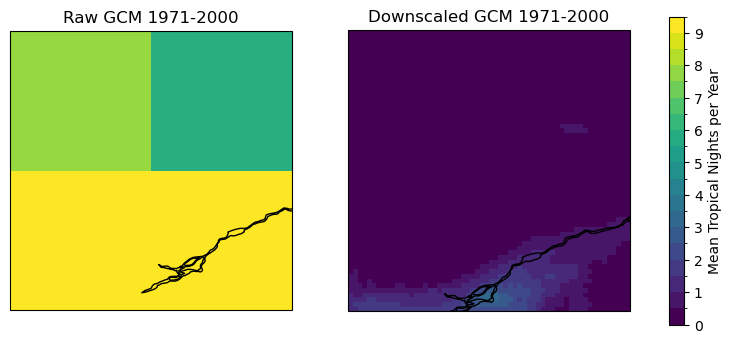

In [11]:
# plot the historical results for both the raw and downscaled data
clevs_tn = np.arange(0, 10, 0.5)
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4), subplot_kw = spkws)
p0 = ds_tn_hist_raw['mean_tn'].plot.pcolormesh(ax = axes[0], levels = clevs_tn, add_colorbar = False)
axes[0].set_title("Raw GCM 1971-2000")
p1 = ds_tn_hist_sds['mean_tn'].plot.pcolormesh(ax = axes[1], levels = clevs_tn, add_colorbar = False)
axes[1].set_title("Downscaled GCM 1971-2000")

fig.colorbar(p1, ax = axes.ravel().tolist(), label = "Mean Tropical Nights per Year")
for ax in axes:
    ax.coastlines()

The downscaling is clearly adding a lot of value to the GCM simulations! The selected domain is covered by only 4 grid cells in the raw model, so basically none of the spatial variability seen in the downscaled data are represented. The raw model data also appears to have a significant high bias in Tropical Nights, which is consistent with the positive summertime tempertaure bias in CanESM5 seen in Section 3.4.

## 4.5.2 Testing Significance of Uncorrected and Downscaled Projected Changes

Now let's look at the projected changes and assess the statistical significance using the two-sample $t$-test and the effective sample size correction.

Becuase we are now working with spatial data instead of a 1D time series, we will be doing many hypothesis tests simultaneously (one for each grid cell). Each hypothesis test comes with a chance of a false positive (Type I error) determined by the $p$-value threshold $\alpha$. A test where $\alpha = 0.05$ is the threshold for rejecting the null hypothesis has a 5% chance of Type I error. For a large spatial domain, with hundreds of grid cells (and thus hundreds of hypothesis tests), this means a substantial number of locations will be affected by Type I error. 

We can correct for the effects of this issue using the *False Discovery Rate* correction {cite}`wilks_statistical_2019`. For this procedure, the $N$ $p$-values (where $N$ is the number of hypothesis tests being conducted) are sorted lowest to highest, and a new significance threshold $\alpha_{FDR}$ is calculated:

$$
\alpha_{FDR} = max_{j=1,...,N} \left(p_{(j)}: p_{(j)} < \frac{j}{N} \alpha_{global} \right)
$$

Here, $\alpha_{global}$ is the significance threshold for the field as a whole (your usual chosen $\alpha$ value, typically 0.05). $p_{(j)}$ is the $j$'th order statistic of the $N$ $p$-values, in other words the $j$'th smallest $p$-value.

If an individual test has $p < \alpha_{FDR}$, then for that location we reject the null hypothesis. If none of the $p_{(j)}$ are less than $\alpha_{FDR}$, then the global null hypothesis of no effect at all $N$ locations is not rejected at the $\alpha_{global}$ significance level. 

In [12]:
# function for calculating FDR-corrected significance threshold
def fdr(p,alpha = 0.1):
    ## p - an array of p-values
    ## alpha - significance p-value threshold
   
    # flatten p
    dims = p.shape
    if len(dims) > 1:
        p = p.flatten()
    sortp = np.sort(p)
    N = len(p)
    slope = np.arange(1,N+1)/N * alpha
    where_p = sortp <= slope
    if np.any(where_p):
        a_fdr = np.max(sortp[where_p])
    else:
        a_fdr = 0
    return a_fdr

In [13]:
# function to do the significance test
def test_significance(ds_hist, ds_future, alpha = 0.05):
    # do the t-test
    tstats, pvals = stats.ttest_ind_from_stats(ds_hist['mean_tn'], ds_hist['std_tn'], ds_hist['neff'],
                                               ds_future['mean_tn'], ds_future['std_tn'], ds_future['neff'],
                                               equal_var = False)

    # get new threshold using alpha_FDR and get array of 1's where p < alpha_FDR (and 0's otherwise)
    alpha_FDR = fdr(pvals.values, alpha = alpha)
    reject_null = np.where(pvals < alpha_FDR, 1, 0)
    
    return reject_null

In [14]:
# do the significance testing
reject_null_raw = test_significance(ds_tn_hist_raw, ds_tn_future_raw)
reject_null_sds = test_significance(ds_tn_hist_sds, ds_tn_future_sds)

We can visualize the results of the significance testing by plotting maps of the climate change response, and adding stippling on grid cells for which the null hypothesis is rejected. We'll also plot maps of the historical and future projected mean annual Tropical Nights, as another way of visualizing the climate change signal (click to reveal the code).

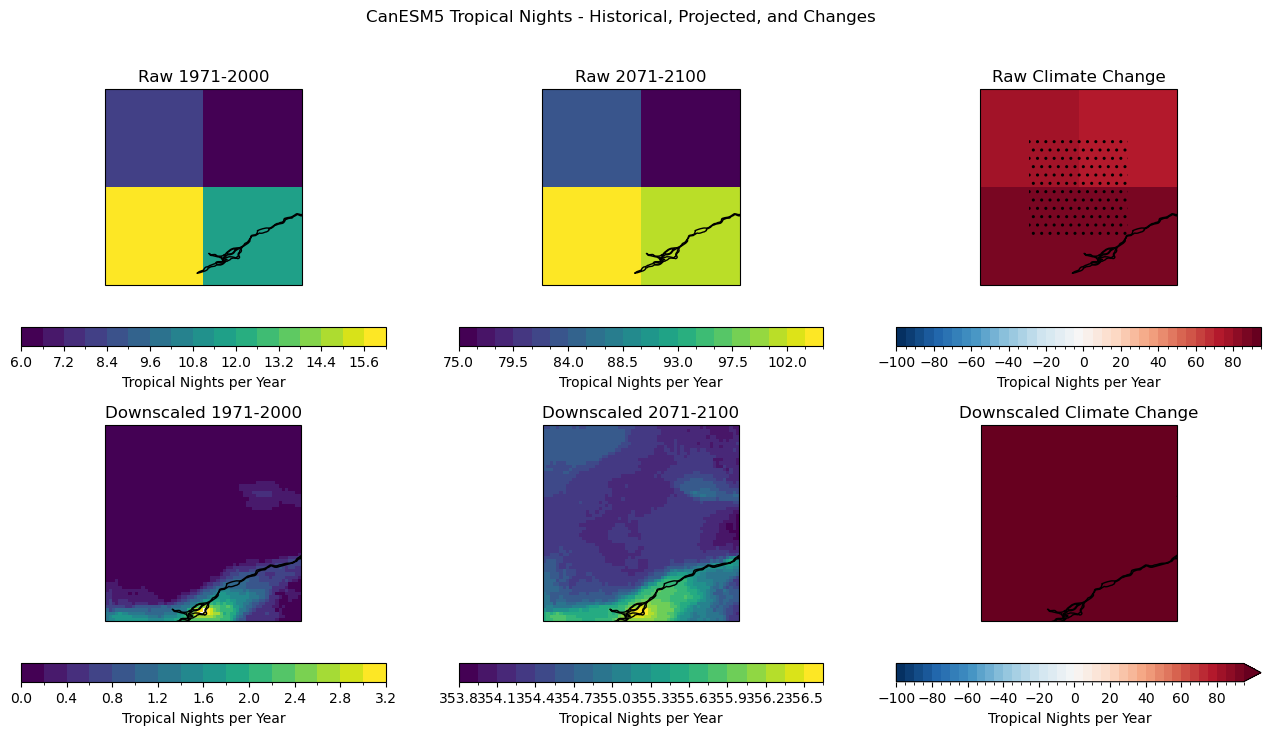

In [15]:
# plot maps for the three cases - historical, future, and the change, for both the raw and downscaled model
# on the delta plot, add stippling to indicate where the changes are statstically significant
clevs_delta = np.arange(-100, 100, 5)

cbar_kwargs = dict(orientation = 'horizontal', label = "Tropical Nights per Year")

fig, axes_2d = plt.subplots(ncols = 3, nrows = 2, figsize = (16, 8), subplot_kw = spkws)
axes = axes_2d.flatten()
fig.suptitle("CanESM5 Tropical Nights - Historical, Projected, and Changes")

# raw model
p1 = ds_tn_hist_raw['mean_tn'].plot.pcolormesh(ax = axes[0], levels = 20, cbar_kwargs = cbar_kwargs)
axes[0].set_title("Raw 1971-2000")

p2 = ds_tn_future_raw['mean_tn'].plot.pcolormesh(ax = axes[1], levels = 20, cbar_kwargs = cbar_kwargs)
axes[1].set_title("Raw 2071-2100")

delta_tn_raw = ds_tn_future_raw['mean_tn'] - ds_tn_hist_raw['mean_tn']
p3 = delta_tn_raw.plot.pcolormesh(ax = axes[2], levels = clevs_delta, cbar_kwargs = cbar_kwargs)
axes[2].set_title("Raw Climate Change")

# add dots (stippling) where reject_null == 1 using plt.contourf
lons = delta_tn_raw.lon
lats = delta_tn_raw.lat
axes[2].contourf(lons, lats, reject_null_raw, alpha = 0, levels = [-1, 0, 1], hatches = ["", ".."])

# downscaled model
p4 = ds_tn_hist_sds['mean_tn'].plot.pcolormesh(ax = axes[3], levels = 20, cbar_kwargs = cbar_kwargs)
axes[3].set_title("Downscaled 1971-2000")

p5 = ds_tn_future_sds['mean_tn'].plot.pcolormesh(ax = axes[4], levels = 20, cbar_kwargs = cbar_kwargs)
axes[4].set_title("Downscaled 2071-2100")

delta_tn_sds = ds_tn_future_sds['mean_tn'] - ds_tn_hist_sds['mean_tn']
p6 = delta_tn_sds.plot.pcolormesh(ax = axes[5], levels = clevs_delta, cbar_kwargs = cbar_kwargs)
axes[5].set_title("Downscaled Climate Change")

# add dots (stippling) where reject_null == 1 using plt.contourf
lons = delta_tn_sds.lon
lats = delta_tn_sds.lat
axes[5].contourf(lons, lats, reject_null_sds, alpha = 0, levels = [-1, 0, 1], hatches = ["", ".."])

for ax in axes:
    ax.coastlines()
plt.show()

Comparing the raw and downscaled model data, both show very large increases to the number of Tropical Nights. While the raw simulations are biases high relative to observations (and to the downscaled data), the climate change differences are comparable in magnitude. As mentioned at the start of this notebook, this is a property of univariate statistical downscaling. The downscaling method itself cannot substantially alter the nature of the future projections from the model, all it can do is add spatial detail and adjust for biases relative to historical observations.

Because the projected changes for this metric are so huge, the changes are statistically significant nearly everywhere in the chosen domain. The changes are too large for us to use a common range of contour intervals for both the historical and future scenarios! Remember that CanESM5 is somewhat of an outlier model in terms of the amount of projected warming, so the downscaled projections for this model will show greater increases to indices like Tropical Nights than other models which fall closer to the middle of the range of warming projections. Choosing a model with lower climate sensitivity will likely show smaller increases to indices of extreme heat, but nevertheless are still likely to have statistically significant results, since increasing temperature is amongst the most robust of any climate change projections. 

For more noisy variables, like precipitation, you may not detect significant changes to your climate index of interest, or some models may project significant changes while others do not. This is something that cannot be emphasized enough - if your impact study does not include results from multiple models, then you are very likely undersampling uncertainty due to variations in modeling choices. Including only CanESM5 might lead you to overestimate potential impacts of changes to heat extremes, but equivalently using only a model on the low end of warming projections would lead to underestimation of the impacts. The only way to know where a given model lies on the spectrum of projections is to perform a multi-model analysis.
 